In [1]:
# Disease Diagnosis Prediction using PIMA Diabetes Dataset

# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, f1_score, roc_auc_score, roc_curve, confusion_matrix

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings('ignore')


In [3]:
# 2. Load Dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
columns = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin",
           "BMI", "DiabetesPedigreeFunction", "Age", "Outcome"]
df = pd.read_csv(url, names=columns)

df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  

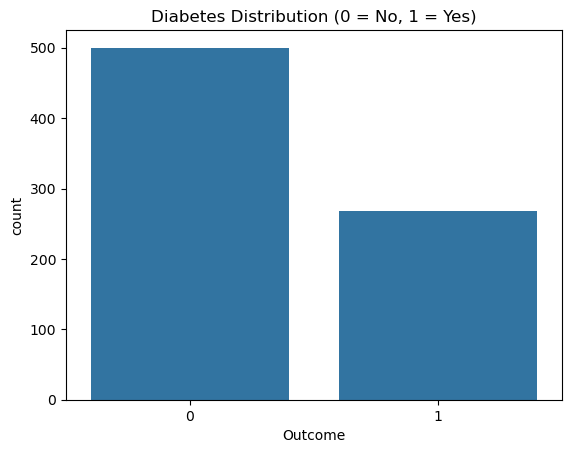

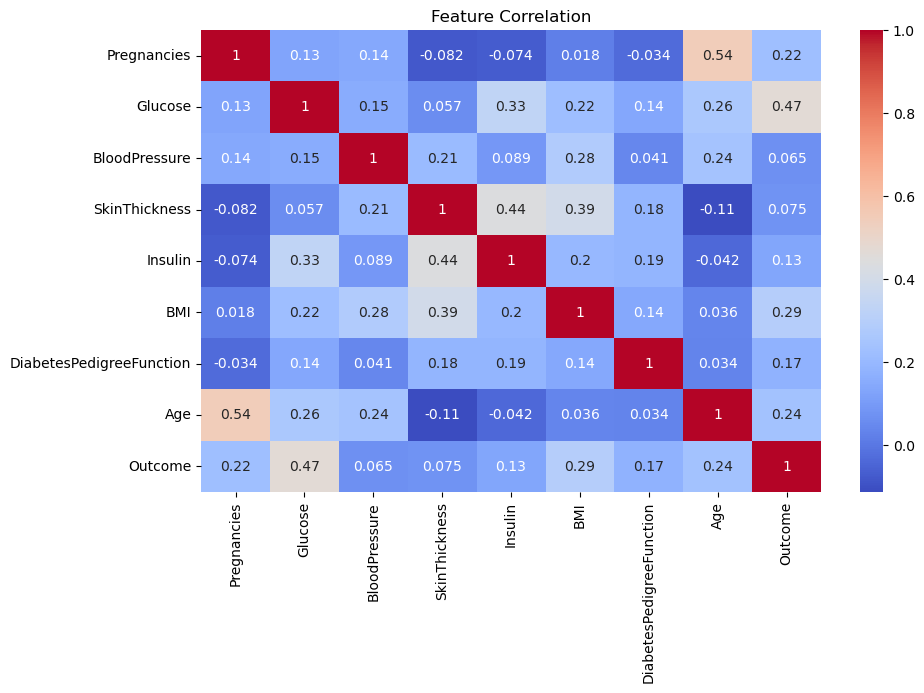

In [5]:
# 3. Exploratory Data Analysis (EDA)

print(df.describe())

# Check for missing values (zeros in medical fields = possible missing)
zero_features = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
print("Zero values per column:")
print((df[zero_features] == 0).sum())

# Visualize outcome distribution
sns.countplot(x='Outcome', data=df)
plt.title("Diabetes Distribution (0 = No, 1 = Yes)")
plt.show()

# Correlation Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation")
plt.show()


In [7]:
# 4. Replace zeros with NaN, then fill with median
for col in zero_features:
    df[col] = df[col].replace(0, np.nan)
    df[col].fillna(df[col].median(), inplace=True)

# Confirm no NaNs
print(df.isnull().sum())


Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [9]:
# 5. Feature Selection using ANOVA F-test
X = df.drop('Outcome', axis=1)
y = df['Outcome']

selector = SelectKBest(score_func=f_classif, k=6)
X_new = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]
print("Selected Features:", selected_features.tolist())

X = df[selected_features]


Selected Features: ['Pregnancies', 'Glucose', 'SkinThickness', 'Insulin', 'BMI', 'Age']


In [11]:
# 6. Data Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [13]:
# 7. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y)


In [15]:
# 8. Model Training

# Gradient Boosting
gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_train, y_train)

# Support Vector Machine
svm = SVC(probability=True, random_state=42)
svm.fit(X_train, y_train)

# Neural Network
mlp = MLPClassifier(hidden_layer_sizes=(20,), max_iter=300, random_state=42)
mlp.fit(X_train, y_train)


MLPClassifier(hidden_layer_sizes=(20,), max_iter=300, random_state=42)


Gradient Boosting Evaluation:
              precision    recall  f1-score   support

           0       0.80      0.83      0.81       100
           1       0.66      0.61      0.63        54

    accuracy                           0.75       154
   macro avg       0.73      0.72      0.72       154
weighted avg       0.75      0.75      0.75       154

F1 Score: 0.6346153846153846
AUC-ROC: 0.8227777777777778

SVM Evaluation:
              precision    recall  f1-score   support

           0       0.75      0.82      0.78       100
           1       0.60      0.50      0.55        54

    accuracy                           0.71       154
   macro avg       0.68      0.66      0.67       154
weighted avg       0.70      0.71      0.70       154

F1 Score: 0.5454545454545454
AUC-ROC: 0.7777777777777778

Neural Network Evaluation:
              precision    recall  f1-score   support

           0       0.79      0.82      0.80       100
           1       0.64      0.59      0.62    

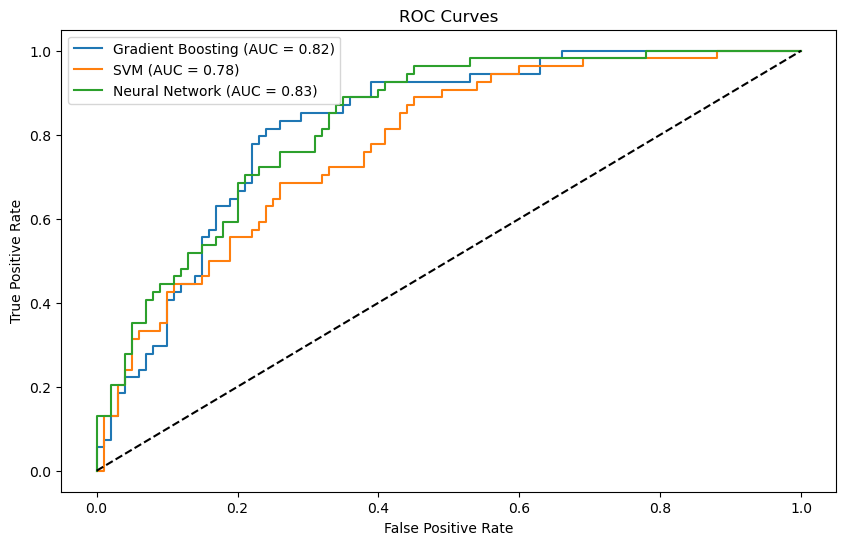

In [17]:
# 9. Evaluation Function
def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]

    print(f"\n{name} Evaluation:")
    print(classification_report(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("AUC-ROC:", roc_auc_score(y_test, y_proba))

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_test, y_proba):.2f})")

# Plot ROC Curves
plt.figure(figsize=(10,6))
evaluate_model(gbc, X_test, y_test, "Gradient Boosting")
evaluate_model(svm, X_test, y_test, "SVM")
evaluate_model(mlp, X_test, y_test, "Neural Network")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


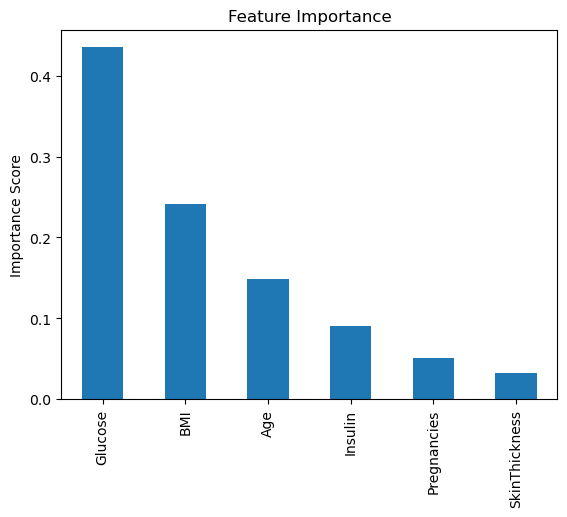

🔍 Top Insights:
1. Glucose levels and BMI are strong predictors of diabetes risk.
2. Early intervention for high-risk individuals can be prioritized.
3. Combining age with medical metrics improves prediction accuracy.


In [19]:
# 10. Insights for Healthcare Professionals

# Feature Importance from Gradient Boosting
feature_importance = pd.Series(gbc.feature_importances_, index=selected_features)
feature_importance.sort_values(ascending=False).plot(kind='bar', title='Feature Importance')
plt.ylabel("Importance Score")
plt.show()

print("🔍 Top Insights:")
print("1. Glucose levels and BMI are strong predictors of diabetes risk.")
print("2. Early intervention for high-risk individuals can be prioritized.")
print("3. Combining age with medical metrics improves prediction accuracy.")


In [25]:
# ✅ Match features used in training
new_patient = pd.DataFrame([{
    'Pregnancies': 2,
    'Glucose': 130,
    'BloodPressure': 80,
    'SkinThickness': 25,
    'Insulin': 100,
    'BMI': 32.0,
    'DiabetesPedigreeFunction': 0.45,
    'Age': 35
}])

# Select only relevant features
new_patient = new_patient[selected_features]

# Scale the features
new_patient_scaled = scaler.transform(new_patient)

# Make prediction
prediction = gbc.predict(new_patient_scaled)[0]
probability = gbc.predict_proba(new_patient_scaled)[0][1]

# Show result
print("🧪 Prediction for new patient:")
print("Diabetes Likely?", "✅ Yes" if prediction == 1 else "❌ No")
print(f"Probability of Diabetes: {probability:.2f}")


🧪 Prediction for new patient:
Diabetes Likely? ✅ Yes
Probability of Diabetes: 0.53
